# Exploratory Data Analysis - Principal Component Analysis with Full Image Data

In [1]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sn
import warnings
warnings.filterwarnings("ignore")

## Helper Functions

The standard <code>read_data()</code> function seen throughout the project. designed to simplify and standardize the data reading process. <br/>In addition the _Global_ variables associated with its function are defined along with the relitive paths to the data files.<br/>__NOTE:__ in a business environment this function would be placed into a pythin module and imported. Here it is included into the notebook to provide full transparency. 

In [2]:
# required modules
import numpy as np
import pandas as pd
import sqlite3
from sklearn import preprocessing
import colorsys

# groups
COLOURS      = 10
PALETTES     = 11
LRG_PALETTES = 12
IMAGE        = 13
TILES        = 14

# sets
TRAIN        = 20
TEST         = 21
VALIDATE     = 22

# targets
ARTIST       = 30
GENRE        = 31
STYLE        = 32

# array
DATA         = 40
CATAGORY     = 41
CATAGORY_NUM = 42
IMAGE_TAG    = 43
TILE_INDEX   = 44

# colour systems
HLS          = 50
RGB          = 51
RAW          = 52

# an overly complicated method of defining the data file path
data_file  = {COLOURS      : {TRAIN    : {ARTIST : "./data/colour_sets/artist_train_colours.npz",
                                          GENRE  : "./data/colour_sets/genre_train_colours.npz",
                                          STYLE  : "./data/colour_sets/style_train_colours.npz"},
                              TEST     : {ARTIST : "./data/colour_sets/artist_test_colours.npz",
                                          GENRE  : "./data/colour_sets/genre_test_colours.npz",
                                          STYLE  : "./data/colour_sets/style_test_colours.npz"} ,
                              VALIDATE : {ARTIST : "./data/colour_sets/artist_validation_colours.npz",
                                          GENRE  : "./data/colour_sets/genre_validation_colours.npz",
                                          STYLE  : "./data/colour_sets/style_validation_colours.npz"}},
              PALETTES     : {TRAIN    : {ARTIST : "./data/palette_sets/artist_train_palettes.npz",
                                          GENRE  : "./data/palette_sets/genre_train_palettes.npz",
                                          STYLE  : "./data/palette_sets/style_train_palettes.npz"} ,
                              TEST     : {ARTIST : "./data/palette_sets/artist_test_palettes.npz",
                                          GENRE  : "./data/palette_sets/genre_test_palettes.npz",
                                          STYLE  : "./data/palette_sets/style_test_palettes.npz"} ,
                              VALIDATE : {ARTIST : "./data/palette_sets/artist_validation_palettes.npz",
                                          GENRE  : "./data/palette_sets/genre_validation_palettes.npz",
                                          STYLE  : "./data/palette_sets/style_validation_palettes.npz"}},
              LRG_PALETTES : {TRAIN    : {ARTIST : "./data/large_palette_sets/artist_train_palettes.npz",
                                          GENRE  : "./data/large_palette_sets/genre_train_palettes.npz",
                                          STYLE  : "./data/large_palette_sets/style_train_palettes.npz"} ,
                              TEST     : {ARTIST : "./data/large_palette_sets/artist_test_palettes.npz",
                                          GENRE  : "./data/large_palette_sets/genre_test_palettes.npz",
                                          STYLE  : "./data/large_palette_sets/style_test_palettes.npz"} ,
                              VALIDATE : {ARTIST : "./data/large_palette_sets/artist_validation_palettes.npz",
                                          GENRE  : "./data/large_palette_sets/genre_validation_palettes.npz",
                                          STYLE  : "./data/large_palette_sets/style_validation_palettes.npz"}},
              IMAGE        : {TRAIN    : {ARTIST : "./data/full_image_feature_sets/artist_train_features.npz",
                                          GENRE  : "./data/full_image_feature_sets/genre_train_features.npz",
                                          STYLE  : "./data/full_image_feature_sets/style_train_features.npz"} ,
                              TEST     : {ARTIST : "./data/full_image_feature_sets/artist_test_features.npz",
                                          GENRE  : "./data/full_image_feature_sets/genre_test_features.npz",
                                          STYLE  : "./data/full_image_feature_sets/style_test_features.npz"} ,
                              VALIDATE : {ARTIST : "./data/full_image_feature_sets/artist_validation_features.npz",
                                          GENRE  : "./data/full_image_feature_sets/genre_validation_features.npz",
                                          STYLE  : "./data/full_image_feature_sets/style_validation_features.npz"}},
              TILES        : {TRAIN    : {ARTIST : "./data/feature_sets/artist_train_features.npz",
                                          GENRE  : "./data/feature_sets/genre_train_features.npz",
                                          STYLE  : "./data/feature_sets/style_train_features.npz"} ,
                              TEST     : {ARTIST : "./data/feature_sets/artist_test_features.npz",
                                          GENRE  : "./data/feature_sets/genre_test_features.npz",
                                          STYLE  : "./data/feature_sets/style_test_features.npz"} ,
                              VALIDATE : {ARTIST : "./data/feature_sets/artist_validation_features.npz",
                                          GENRE  : "./data/feature_sets/genre_validation_features.npz",
                                          STYLE  : "./data/feature_sets/style_validation_features.npz"}}}

# Create a DB connection between python and the file system
conn = sqlite3.connect("./data/database/artist.db")

# the fuction that provides a standard data read method
def read_data(data_group, data_set, data_target, data_type, colour_system = RGB):
    
    # read the data file
    data = np.load(data_file[data_group][data_set][data_target], allow_pickle=True)

    # if tile index is requested
    if   data_type    == TILE_INDEX:
        # when group is tiles, return the tile indexes
        if data_group == TILES:
            return pd.DataFrame(data["arr_3"], columns = {"tile_index"})
        # otherwise, just return an emtpy dataset
        else:
            return pd.DataFrame(columns = {"tile_index"})
    # if image tags are requested
    elif data_type == IMAGE_TAG:
        return pd.DataFrame(data["arr_2"], columns = {"image_tag"})
    # if catagory data is requested
    elif data_type == CATAGORY:
        return pd.DataFrame(data["arr_1"], columns = {"catagory"})
    # if catagory_num is requested
    elif data_type == CATAGORY_NUM:
        # select data for the appropriate lookup table
        if   data_target == ARTIST: 
            query_string = "SELECT ID, NAME  AS VALUE FROM ARTIST"
        elif data_target == GENRE:
            query_string = "SELECT ID, GENRE AS VALUE FROM GENRE"
        else:
            query_string = "SELECT ID, STYLE AS VALUE FROM STYLE" 
        # build the lookup table
        lookup = pd.read_sql_query(query_string, conn)
        # get the catagory data
        data   = pd.DataFrame(data["arr_1"], columns = {"catagory"})
        # convert the catagory text labels to numeric catagory ids
        return pd.DataFrame(data["catagory"].apply(lambda x: lookup[lookup["VALUE"] == x]["id"].values[0]))
    # data requested
    elif data_group == COLOURS:
        # reshape the data and normalize
        return pd.DataFrame(preprocessing.normalize(data["arr_0"].reshape(data["arr_0"].shape[0],data["arr_0"].shape[1] * data["arr_0"].shape[2])))
    elif data_group == PALETTES or data_group == LRG_PALETTES:

        # extract the colour data
        colour_data = data["arr_0"]
        
        # find the datas dimensions
        records, _, palette_length, palette_layers = np.shape(colour_data)
        
        # reshape
        colour_data = colour_data.reshape(records * palette_length, palette_layers)
        
        # convert to a dataframe
        colour_data_df = pd.DataFrame(colour_data, columns =["r","g","b"])
        
        # process the data with different colour systems
        
        # hue, luminance, saturation
        if colour_system == HLS:
            
            # define a dataframe to hold the hls values
            hls_data_df = pd.DataFrame(columns =["h","l","s"])

            # loop through each record
            for row in colour_data_df.iterrows():
                
                # extract the r,g,b values and devide them by 255 ready to convert
                r, g, b = row[1].values/255

                # convert the values and add them to the dataframe
                hls_data_df.loc[len(hls_data_df)] = colorsys.rgb_to_hls(r, g, b)
            
            # create datasets and normalize
            hue        = pd.DataFrame(preprocessing.normalize(np.array(hls_data_df["h"]).reshape(records, palette_length)))
            luminance  = pd.DataFrame(preprocessing.normalize(np.array(hls_data_df["l"]).reshape(records, palette_length)))
            saturation = pd.DataFrame(preprocessing.normalize(np.array(hls_data_df["s"]).reshape(records, palette_length)))  
            
            # return values
            return hue, luminance, saturation
            
        # red, green, blue unnormalized
        elif colour_system == RAW:
            red   = pd.DataFrame(np.array(colour_data_df["r"]).reshape(records, palette_length))
            green = pd.DataFrame(np.array(colour_data_df["g"]).reshape(records, palette_length))
            blue  = pd.DataFrame(np.array(colour_data_df["b"]).reshape(records, palette_length))
            
            # return values
            return red, green, blue            
            
        # red, green, blue normalized- (default)
        else:
    
            # create datasets and normalize
            red   = pd.DataFrame(preprocessing.normalize(np.array(colour_data_df["r"]).reshape(records, palette_length)))
            green = pd.DataFrame(preprocessing.normalize(np.array(colour_data_df["g"]).reshape(records, palette_length)))
            blue  = pd.DataFrame(preprocessing.normalize(np.array(colour_data_df["b"]).reshape(records, palette_length)))
            
            # return values
            return red, green, blue

    elif data_group == IMAGE:
        # reshape the data and normalize
        return pd.DataFrame(preprocessing.normalize(data["arr_0"].reshape(data["arr_0"].shape[0],data["arr_0"].shape[2])))
    else:
        # normalize the data
        return pd.DataFrame(preprocessing.normalize(data["arr_0"])) 

The Function <code>read_filtered_data_by_artist()</code> requires a data group from __COLOURS, PALETTES, LRG_PALETTES, IMAGE__ or __TILES__, a data set from __TRAIN, TEST__ or __VALIDATION__ and an artists name. A filtered data set matching these parameters is then returned

In [3]:
def read_filtered_data_by_artist(data_group, data_set, artist):
    
    # read all matching data
    data = read_data(data_group, data_set, ARTIST , DATA)
    
    # generate a filter that is only true for the artist 
    data_filter = read_data(data_group, data_set, ARTIST, CATAGORY) == artist
    
    # apply the filter to the data and return
    return data[data_filter["catagory"]]

The Function <code>read_tile_data_by_image_tag()</code> requires a data group from __COLOURS, PALETTES, LRG_PALETTES, IMAGE__ or __TILES__, a data set from __TRAIN, TEST__ or __VALIDATION__ and an __IMAGE_TAG__. A filtered data set matching these parameters is then returned

In [4]:
def read_tile_data_by_image_tag(data_set, data_target, image_tag):
    
    # read all matching data
    data = read_data(TILES, data_set, data_target, DATA)
    
    # generate a filter that is only true for the image_tag 
    data_filter = read_data(TILES, data_set, data_target, IMAGE_TAG ) == image_tag
    
    # apply the filter to the data and return
    return data[data_filter["image_tag"]]

The Function <code>get_image_for_image_tag()</code> takes an __IMAGE_TAG__ and returns the content of the corresponding image file.

In [5]:
# required modules
import matplotlib.pyplot as plt
from PIL import Image

def get_image_for_image_tag(image_tag):
    
    # construct path to images
    data_file_path  = "./data/"
    image_file_path = "".join([data_file_path, "images/"]) 
    image_path = "".join([image_file_path, "full_image_", image_tag ,".jpg"])
    
    # return the opened image
    return Image.open(image_path)

The Functions <code>red_data_only()</code>, <code>green_data_only()</code> & <code>blue_data_only()</code> extract just their relivant colour data from a colour data set and return it.

The <code>get_colours()</code> function provides a list of colours the length of the value <code>no_of_colours</code>. This can be useful for consisten colours when used across multiple plots. 

In [ ]:
# required modules
import random

# define colours used 
def get_colours(no_of_colours):
    
    # consistent randomness
    random.seed(42)
    
    # colour list
    colours = []

    # generate colours
    for i in range(no_of_colours):
        colours.append("#%06X" % random.randint(0, 0xFFFFFF))
    
    # return the colour list
    return colours

Generate sorted lists of _Artists, Genres_ & _Styles_. These are used in a variety of situations. These functions ensure that the lists are always defined in the same order.

In [7]:
# define data lists
artists = list(set(read_data(COLOURS, TRAIN, ARTIST, CATAGORY)["catagory"]))
styles  = list(set(read_data(COLOURS, TRAIN, STYLE,  CATAGORY)["catagory"]))
genres  = list(set(read_data(COLOURS, TRAIN, GENRE,  CATAGORY)["catagory"]))

# sort the lists
artists.sort()
styles.sort()
genres.sort()

The Function <code>create_pca_2_component_dataset()</code> with Training and Target data provided the data is fitted and the first two __PCA__ components are identified. They are linked to their Catagory values (_Either an Artist name, Genre_ or _Style_) and returned.

In [7]:
def create_pca_2_component_dataset(X_data, y_data, catagory_data):
    # Create PCA transformer
    pca = PCA(n_components=None)

    # Apply PCA
    pca.fit(X_data, y_data);

    # Project data onto the first two components
    X_2d = pca.transform(X_data)

    # convert first 2 components to a dataframe and rename
    df_X2d = pd.DataFrame(X_2d)[[1,2]]
    df_X2d.columns =['1st_component','2nd_component']

    # add catagories to the data as numeric values
    df_X2d['label'] = catagory_data["catagory"]
    
    return df_X2d

The Function <code>grid_plot_target_components()</code> provides the plotting functionality to plot the individual visualizations of the function <code>grid_target_components()</code>.

In [ ]:
# prepare plot for grid figure
def grid_plot_target_components(pca_dataset, ax, target, colour, subtraction):
    
    data     = pca_dataset[pca_dataset['label'] == target]
    sub_data = pca_dataset[pca_dataset['label'] != target]
    
    # construct plot of targets data
    ax.scatter(data["1st_component"],
               data["2nd_component"], 
               s     = 60, 
               alpha = .3 + (subtraction * 0.7), 
               c     = colour)
    
    # remove other targets data overlaps
    if subtraction:
        ax.scatter(sub_data["1st_component"],
                   sub_data["2nd_component"], 
                   s     = 60, 
                   alpha = 1, 
                   c     = "white")    
    
    # prepare plots other visuals
    ax.set_xlabel("1st Component", 
                  fontsize = 10)
    ax.set_ylabel("2nd Component", 
                  fontsize = 10)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(target, 
                 fontsize=12)

The Function <code>grid_target_components()</code> generates a grid to display plots and then calls the function <code>grid_plot_target_components()</code> to populate each of the grid cells.

In [8]:
# prepare grid figure 
def grid_target_components(pca_dataset, targets, title, subtraction = False):
    
    plots_per_grid_row = 5
    
    colours = get_colours(len(targets))
    
    # calculate the number of grid rows
    if len(targets) % plots_per_grid_row == 0:
        grid_rows = len(targets) / plots_per_grid_row
    else:
        grid_rows = int(len(targets) / plots_per_grid_row) + 1

    # define the figure grid
    fig, axs = plt.subplots(nrows = grid_rows, ncols = plots_per_grid_row, constrained_layout = False, figsize = (25, grid_rows * 5))

    # display the title
    fig.suptitle(title, fontsize=16, y = .93)

    # count the iterations
    counter = 0

    # loop through each figure grid location
    for ax in axs.flat:
    
        # when data is available create a plot
        try:
            grid_plot_target_components(pca_dataset, ax, targets[counter], colours[counter], subtraction)
        # when no data skip plot
        except:
            pass
    
        #iterate the counter
        counter += 1

The Function <code>create_pca_scree_plot()</code> generates a Scree plot.

In [9]:
def create_pca_scree_plot(X_data, y_data):
    
    # Create PCA transformer
    pca = PCA(n_components = None)

    # Apply PCA
    pca.fit(X_data, y_data);

    # define the figure
    fig = plt.figure(figsize=(25,7))
    
    values = np.arange(pca.n_components_) + 1
    
    plt.plot(values, pca.explained_variance_ratio_, '-', linewidth = 2, c = "navy")
    plt.plot(values, pca.explained_variance_ratio_, 'o', linewidth = 2, c = "cornflowerblue")
    plt.title("Scree Plot")
    plt.xlabel("Principal Component")
    plt.ylabel("Proportion of Variance Explained")
    plt.show()

The function <code>create_pca_variance_percentage_plot()</code> generates a variance plot of the data set.

In [10]:
def create_pca_variance_percentage_plot(X_data, y_data):
    
    # Create PCA transformer
    pca = PCA(n_components = None)

    # Apply PCA
    pca.fit(X_data, y_data);
    
    # the list of percentages that we wish to check
    list_of_percentages = range(5,100,5)

    # define the figure
    fig = plt.figure(figsize=(25,8))

    # internal function to calculate the number of 
    # components required for a give percentage
    def no_of_components_needed_for(percentage):
    
        # the pecentage must be possitive and not more than 100
        if percentage > 0 and percentage <= 100:
            
            #caluclate values
            df_pca = pd.DataFrame(pca.explained_variance_ratio_)
            df_pca["cumulative"] = df_pca.cumsum()
        
            # identify and return the value
            for i in range(0,len(df_pca["cumulative"])):
                if df_pca["cumulative"][i] >= percentage / 100:
                    return i + 1
               
    # define our data
    x = list_of_percentages
    y = list(map(no_of_components_needed_for, list_of_percentages))

    # bars
    x_pos = [i for i, _ in enumerate(x)]

    # plot (and store bars pyhsical size information)
    rects1 = plt.bar(x_pos, y)

    # add labels
    plt.xlabel("Percentage of Variance")
    plt.ylabel("Number of PCA Components")
    plt.title("How Many PCA Components Explain Percentage of Variance")
    plt.xticks(x_pos, x)

    # define function for adding number of components above the bars
    def bar_label(rects):
        for rect in rects:
            height = rect.get_height()
            plt.text(rect.get_x() + rect.get_width()/2., height + 1,
                     "%d" % int(height),
                     ha = "center", 
                     va = "bottom")

    # add labels above the bars
    bar_label(rects1)

    # display the plot
    plt.show()

## Generate a Scree plot

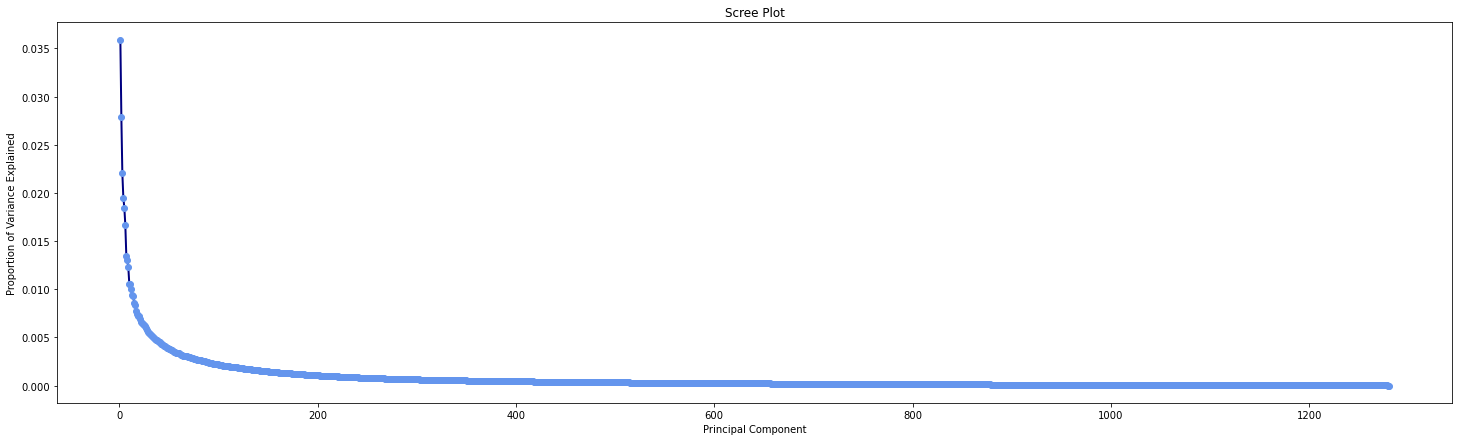

In [11]:
create_pca_scree_plot(read_data(IMAGE, TRAIN, ARTIST, DATA), read_data(IMAGE, TRAIN, ARTIST, CATAGORY_NUM))

## Generate a PCA Variance Plot

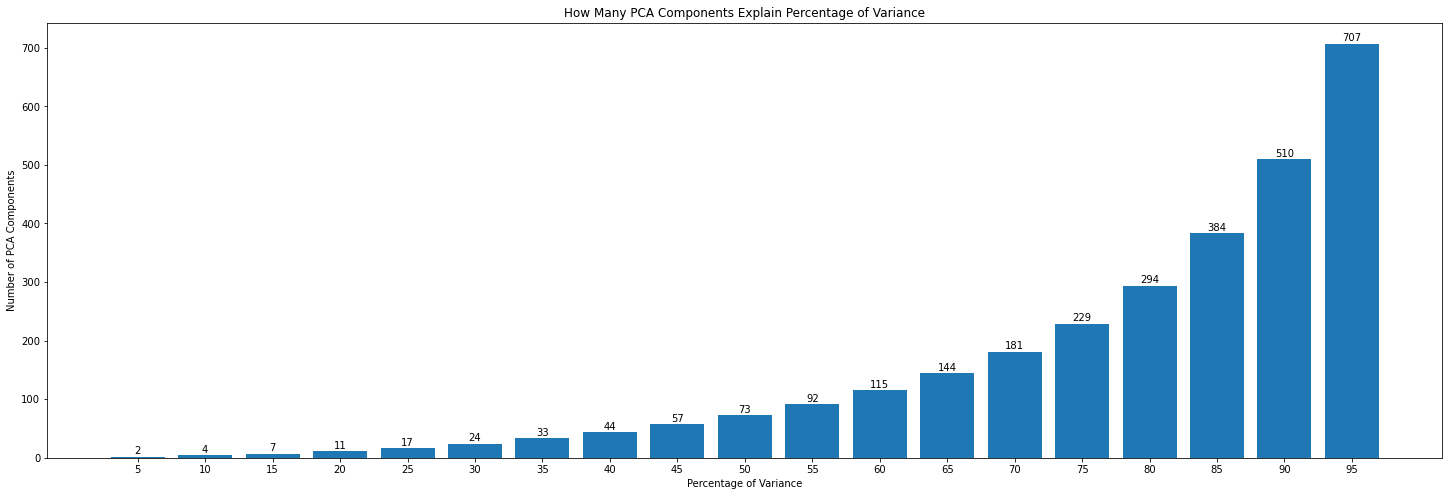

In [12]:
create_pca_variance_percentage_plot(read_data(IMAGE, TRAIN, ARTIST, DATA), read_data(IMAGE, TRAIN, ARTIST, CATAGORY_NUM)) 

## Plot the First 2 PCA Components of the Image Features Data

In [13]:
pca_artist_image_dataset = create_pca_2_component_dataset(read_data(IMAGE, TRAIN, ARTIST, DATA), read_data(IMAGE, TRAIN, ARTIST, CATAGORY_NUM), read_data(COLOURS, TRAIN, ARTIST, CATAGORY))

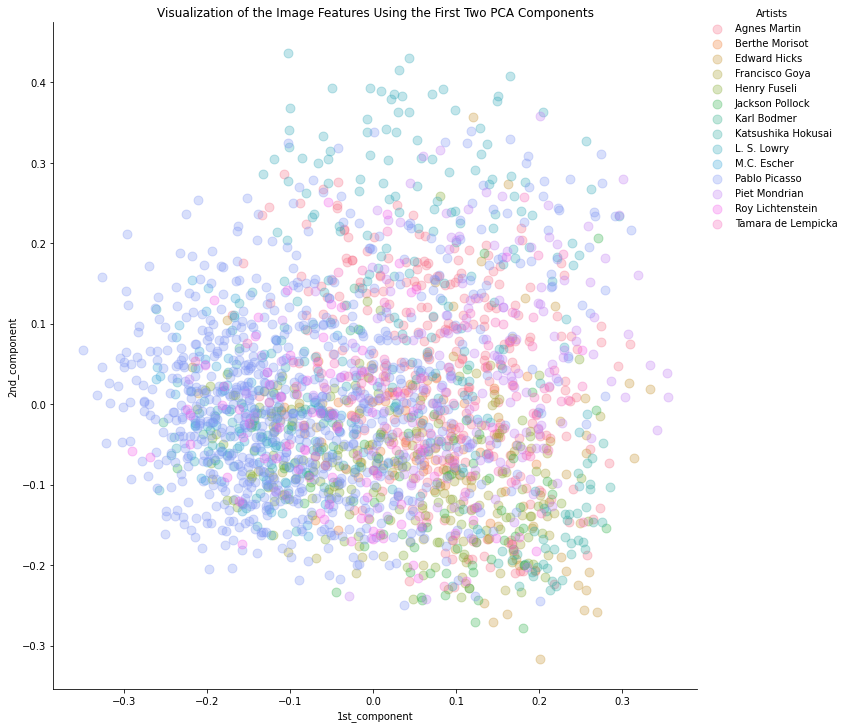

In [14]:
# combined artists image plot 
sn.FacetGrid(pca_artist_image_dataset, hue = "label", height = 10).map(plt.scatter, "1st_component", "2nd_component", s = 80, alpha = 0.3).add_legend(labels = artists, title = "Artists")
plt.title("Visualization of the Image Features Using the First Two PCA Components")
plt.show()

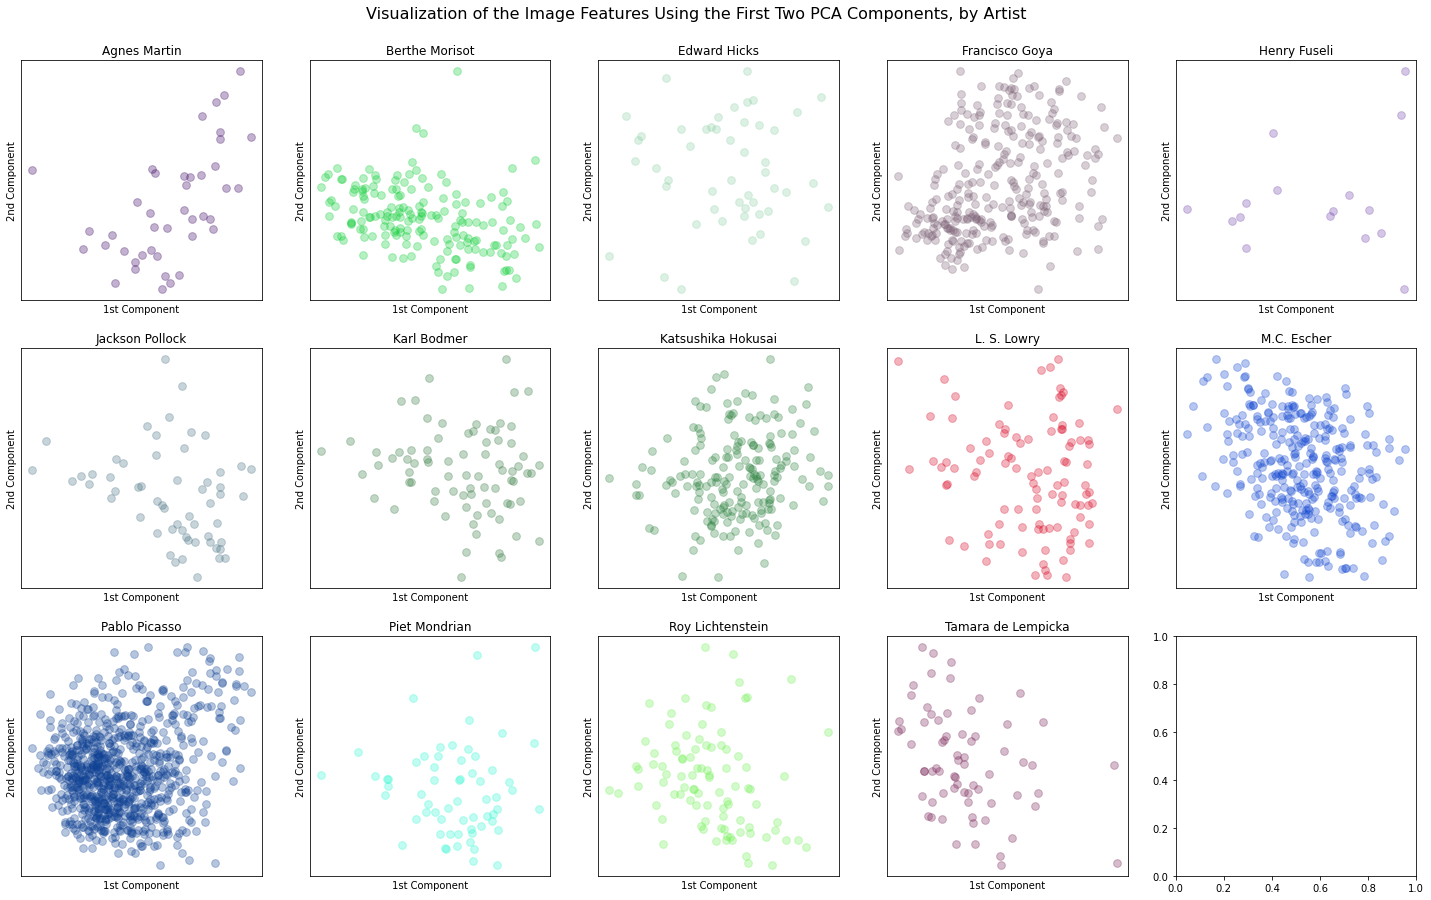

In [15]:
grid_target_components(pca_artist_image_dataset, artists, "Visualization of the Image Features Using the First Two PCA Components, by Artist")

In [16]:
pca_style_image_dataset = create_pca_2_component_dataset(read_data(IMAGE, TRAIN, STYLE, DATA), read_data(IMAGE, TRAIN, STYLE, CATAGORY_NUM), read_data(COLOURS, TRAIN, STYLE, CATAGORY))

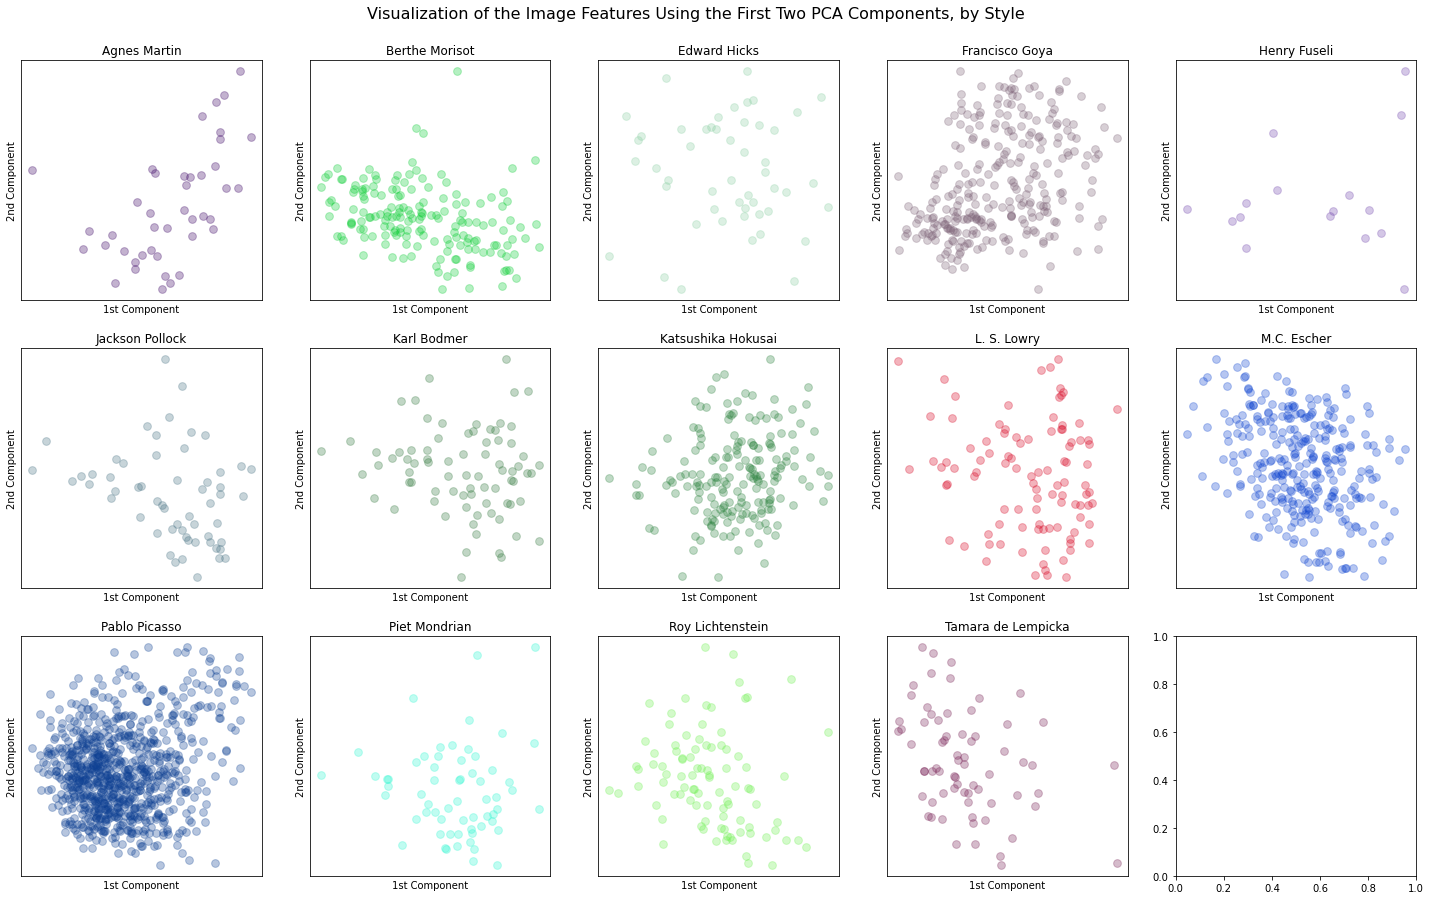

In [17]:
grid_target_components(pca_artist_image_dataset, artists, "Visualization of the Image Features Using the First Two PCA Components, by Style")

In [18]:
pca_genre_image_dataset = create_pca_2_component_dataset(read_data(IMAGE, TRAIN, GENRE, DATA), read_data(IMAGE, TRAIN, GENRE, CATAGORY_NUM), read_data(COLOURS, TRAIN, GENRE, CATAGORY))

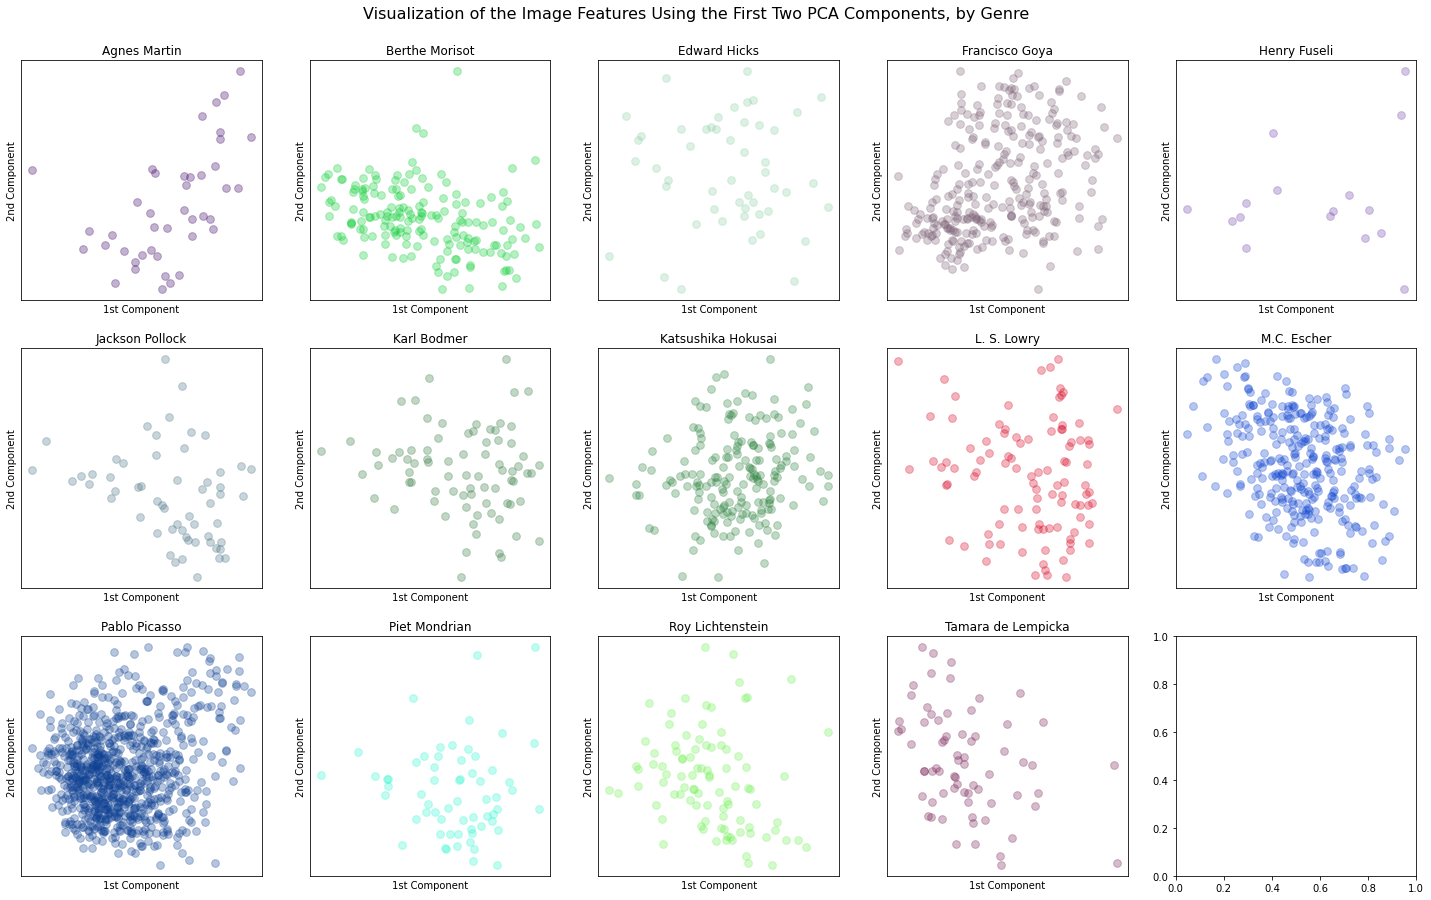

In [19]:
grid_target_components(pca_artist_image_dataset, artists, "Visualization of the Image Features Using the First Two PCA Components, by Genre")